# The Best linear unbiased predictor on a noisy Lotka-Volterra dynamical system

In [1]:
import jax
import chex
import einops
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_3668/3814632302.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

# Simulations

In [3]:
@chex.dataclass
class ParamsLatent:
    alpha: float
    beta: float
    delta: float
    gamma: float
    dt: float
    noise: float


@chex.dataclass
class ParamsObserved:
    noise: float

In [73]:
def latent_step(key, z_prev, params):
    z1, z2 = z_prev
    noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
    
    z1_next = params.alpha * z1 - params.beta * z1 * z2
    z2_next = params.delta * z1 * z2 - params.gamma * z2
    z_next = jnp.array([z1_next, z2_next])
    
    z_next = z_prev + params.dt * z_next + noise
    
    return z_next


def observed_step(key, z_val, params):
    """
    Observed step is simply the current latent
    observed value + gaussian noise
    """
    noise = jax.random.normal(key, (2,)) * params.noise
    obs = z_val + noise
    return obs


def step_latent_observed(z_prev, key, latent_fn, observed_fn,
                             params_latent, params_obs):
    key_latent, key_obs = jax.random.split(key)
    
    z_next = latent_fn(key_latent, z_prev, params_latent)
    x_next = observed_step(key_obs, z_next, params_obs)
    
    res = {
        "latent": z_next,
        "observed": x_next
    }
    return z_next, res
    

def simulate_latent_observed(key, z0, n_steps, latent_fn, observed_fn,
                             params_latent, params_obs):
    key_init, key_sample = jax.random.split(key)
    z0 = z0 + jax.random.uniform(key_init, (2,), minval=-0.2, maxval=0.2)
    # z0 = jax.random.uniform(key_init, (2,), minval=0.5, maxval=0.7)
    
    keys = jax.random.split(key_sample, n_steps)
    part_step_latent_obs = partial(step_latent_observed,
                                   latent_fn=latent_fn,
                                   observed_fn=observed_fn,
                                   params_latent=params_latent,
                                   params_obs=params_obs)
    
    _, hist = jax.lax.scan(part_step_latent_obs, z0, keys)
    return hist


multiple_simulate_latent_observed = jax.vmap(
    simulate_latent_observed,
    in_axes=(0, None, None, None, None, None, None),
    out_axes=-1
)

In [74]:
key = jax.random.PRNGKey(314)
z0 = jnp.array([1.0, 1.0])
params_latent = ParamsLatent(alpha=2/3, beta=4/3, delta=0.8, gamma=1, dt=0.01, noise=0.04)
params_obs = ParamsObserved(noise=0.1)

n_steps = 1500
n_simulations = 24
keys = jax.random.split(key, n_simulations)

simulations = multiple_simulate_latent_observed(keys, z0, n_steps, latent_step, observed_step,
                                                params_latent, params_obs)

latent_sims = simulations["latent"]
measured_sims = simulations["observed"]

*_, dim_latent = latent_sims.shape
*_, dim_inputs = measured_sims.shape

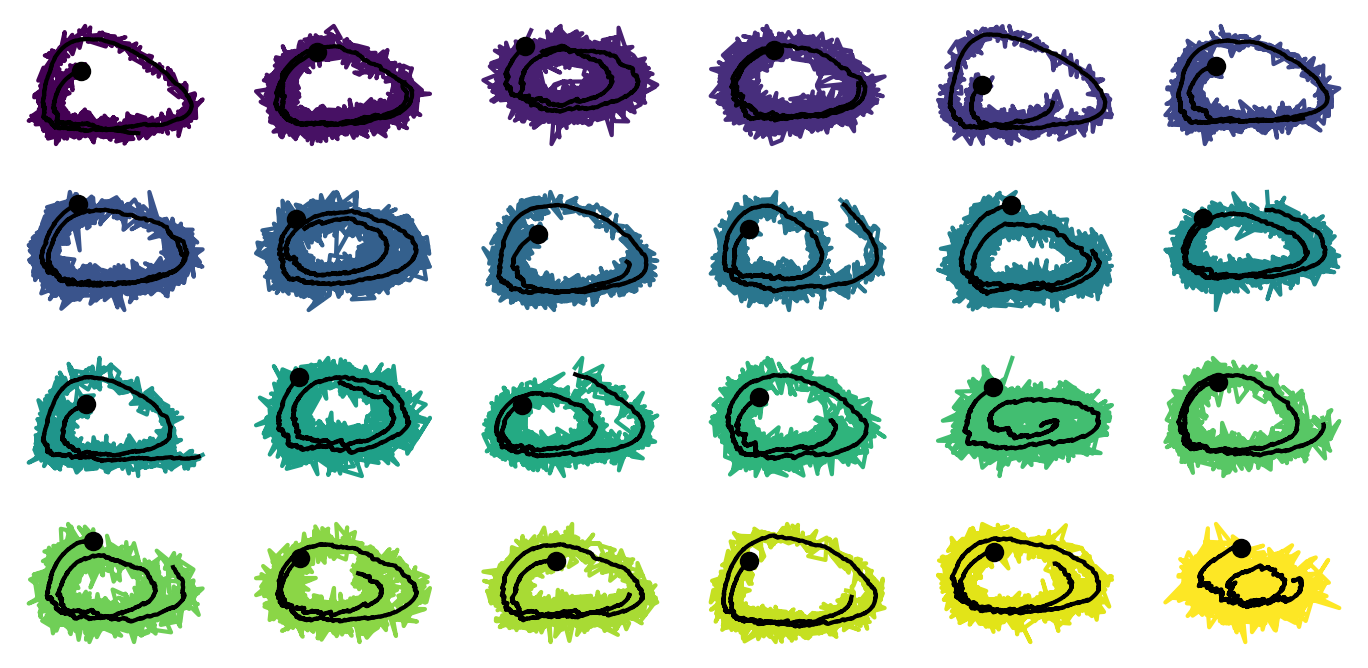

In [75]:
fig, axs = plt.subplots(4, 6, figsize=(7, 3.5))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_simulations))

axs = axs.ravel()
for n, ax in enumerate(axs):
    z_sim = latent_sims[..., n]
    x_sim = measured_sims[..., n]
    ax.plot(*x_sim.T, c=colors[n], zorder=0)
    ax.plot(*z_sim.T, c="black", zorder=1)
    ax.scatter(*z_sim[0], c="black", zorder=2)
    ax.axis("off")
plt.tight_layout()
plt.savefig("samples-process.png", dpi=300, bbox_inches="tight")

## Train phase

In [8]:
key = jax.random.PRNGKey(314)
z0 = jnp.array([1.0, 1.0])
params_latent = ParamsLatent(alpha=2/3, beta=4/3, delta=0.8, gamma=1, dt=0.01, noise=0.02)
params_obs = ParamsObserved(noise=0.05)

n_steps = 1500
n_test = 100
n_simulations = 2000 + n_test
keys = jax.random.split(key, n_simulations)

simulations = multiple_simulate_latent_observed(keys, z0, n_steps, latent_step, observed_step,
                                                params_latent, params_obs)

latent_sims = simulations["latent"]
measured_sims = simulations["observed"]

latent_sims = latent_sims - latent_sims.mean(axis=-1, keepdims=True)
measured_sims = measured_sims - measured_sims.mean(axis=-1, keepdims=True)

latent_sims_test = latent_sims[..., -n_test:]
measured_sims_test = measured_sims[..., -n_test:]

latent_sims = latent_sims[..., :-n_test]
measured_sims = measured_sims[..., :-n_test]

*_, dim_latent = latent_sims.shape
*_, dim_inputs = measured_sims.shape

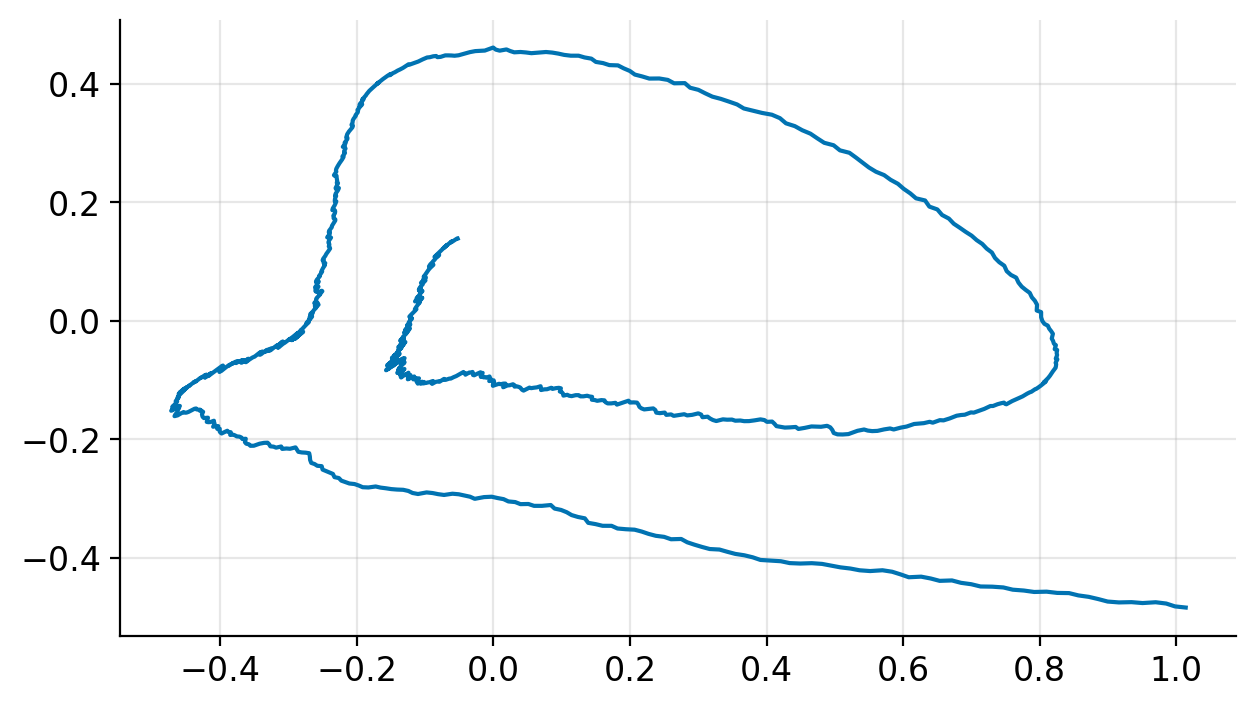

In [9]:
s = 0
plt.plot(*latent_sims[..., s].T)
plt.grid(alpha=0.3)

In [10]:
measured_mean = measured_sims.mean(axis=-1, keepdims=True)

In [11]:
# Covariance
measured_sims_demeaned = measured_sims - measured_mean
V = jnp.einsum("tds,kds->dtk", measured_sims_demeaned, measured_sims_demeaned) / (n_simulations - 1)
V.shape

(2, 1500, 1500)

In [12]:
L = jnp.linalg.cholesky(V)
S = jnp.einsum("dii->di", L)
L = jnp.einsum("dij,dj->dij", L, 1 / S)
S = S ** 2

## Matching variance
$$
    {\rm Var}(y_{1:T}) = {\bf L}\,{\bf S}\,{\bf L}^\intercal,
$$
with
${\bf S} = {\rm diag}(S_1, \ldots, S_T)$, and $S_k = {\rm Var}(\varepsilon_k)$.

In [13]:
# Variance of measurements
jnp.einsum("dii->d", V)

Array([62.77305 , 17.919859], dtype=float32)

In [14]:
# Reconstructed trace of variance from Cholesky
jnp.einsum("dij,dj,dij->d", L, S, L)

Array([62.773098, 17.919846], dtype=float32)

In [15]:
measured_sims.shape

(1500, 2, 2000)

# Computing the BLUP

## Building innovations
$$
    {\bf L}\,\varepsilon_{1:T} = y_{1:T} \implies \varepsilon_t = {\bf L}^{-1}\,y_{1:T}
$$

In [16]:
# Train phase
innovation_sims = jnp.linalg.solve(L, einops.rearrange(measured_sims, "t d s -> d t s"))
innovation_sims = einops.rearrange(innovation_sims, "d t s -> t d s")

## The gain matrix
Recall that the *gain* matrix is defined by
$$
\begin{aligned}
    {\bf K}_{t,k}
    &= {\rm Cov}(F_t, {\cal E}_k)\,S_k^{-1}\\
    &= {\rm Cov}(F_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\\
    &\approx\frac{1}{S}\sum_{s=1}^S\left(f_t^{(s)} - \bar{f}_t\right)\,\left(\varepsilon_k^{(s)} - \bar{\varepsilon}_k\right)^\intercal\,S_k^{-1}
\end{aligned}
$$

In [17]:
latent_mean = latent_sims.mean(axis=-1, keepdims=True)
innovation_mean = innovation_sims.mean(axis=-1, keepdims=True)

latent_demean = latent_sims - latent_mean
innovation_demean = innovation_sims - innovation_mean
K = jnp.einsum("tds,kds,dk->tkd", latent_demean, innovation_demean, 1 / S) / (n_simulations - 1)
K.shape

(1500, 1500, 2)

In [18]:
timesteps = np.linspace(0, 1500 * 0.01, 1500)

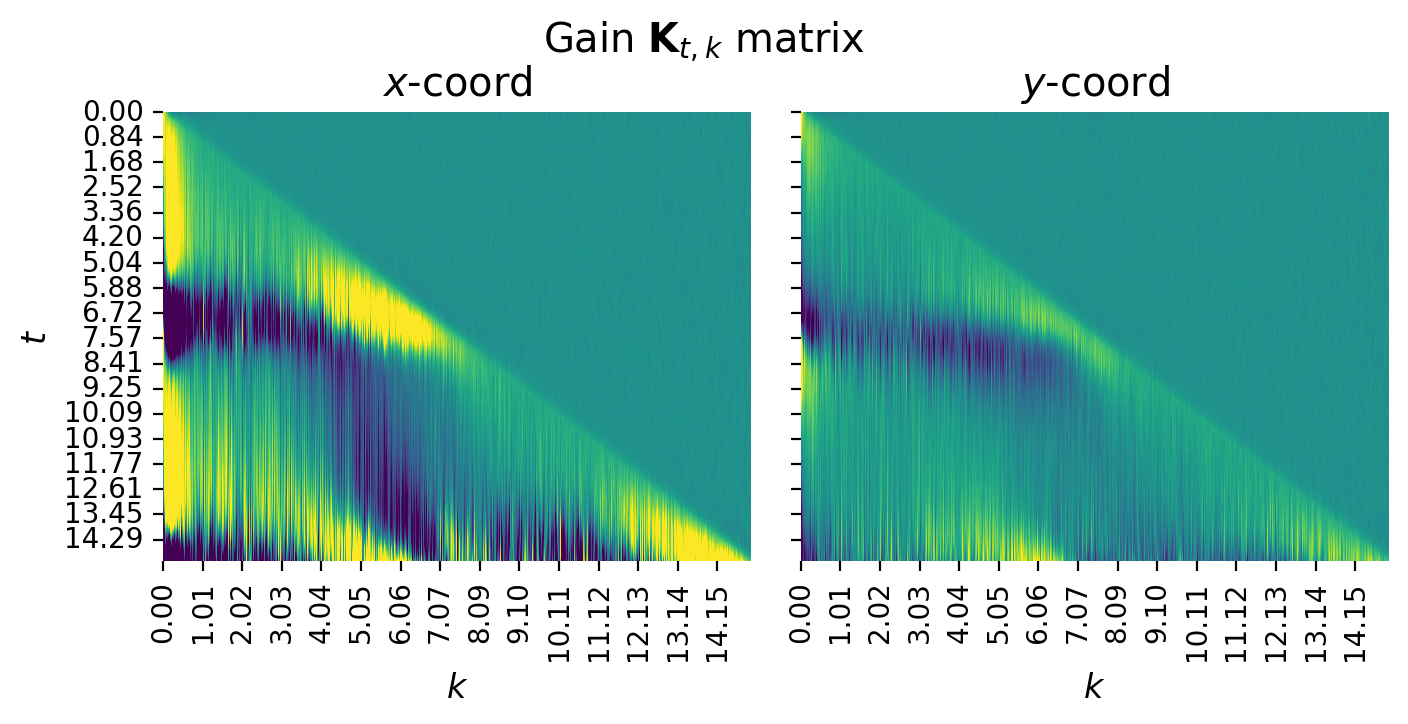

In [77]:
fig, axs = plt.subplots(1, 2, sharey=True)
for d, ax in enumerate(axs):
    Kd = K[..., d]
    Kd = pd.DataFrame(Kd, index=timesteps, columns=timesteps)
    sns.heatmap(
        Kd, cmap="viridis", vmin=-0.2, vmax=0.2, ax=ax, cbar=False
    )


axs[0].set_xlabel("$k$", fontsize=12)
axs[1].set_xlabel("$k$", fontsize=12)
axs[0].set_ylabel("$t$", fontsize=12)
axs[0].set_title("$x$-coord")
axs[1].set_title("$y$-coord")

axs[0].set_yticklabels([format(float(v.get_text()), "0.2f") for v in axs[0].get_yticklabels()], fontsize=10)
for ax in axs:
    ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()], fontsize=10)

plt.suptitle(r"Gain ${\bf K}_{t, k}$ matrix", y=0.90)
plt.tight_layout()
plt.savefig("gain-matrix-sample.png", dpi=300, bbox_inches="tight")

# Test filter

In [20]:
## Build innovations
innovation_sims_test = jnp.linalg.solve(L, einops.rearrange(measured_sims_test, "t d s -> d t s"))
innovation_sims_test = einops.rearrange(innovation_sims_test, "d t s -> t d s")
innovation_sims_test.shape

(1500, 2, 100)

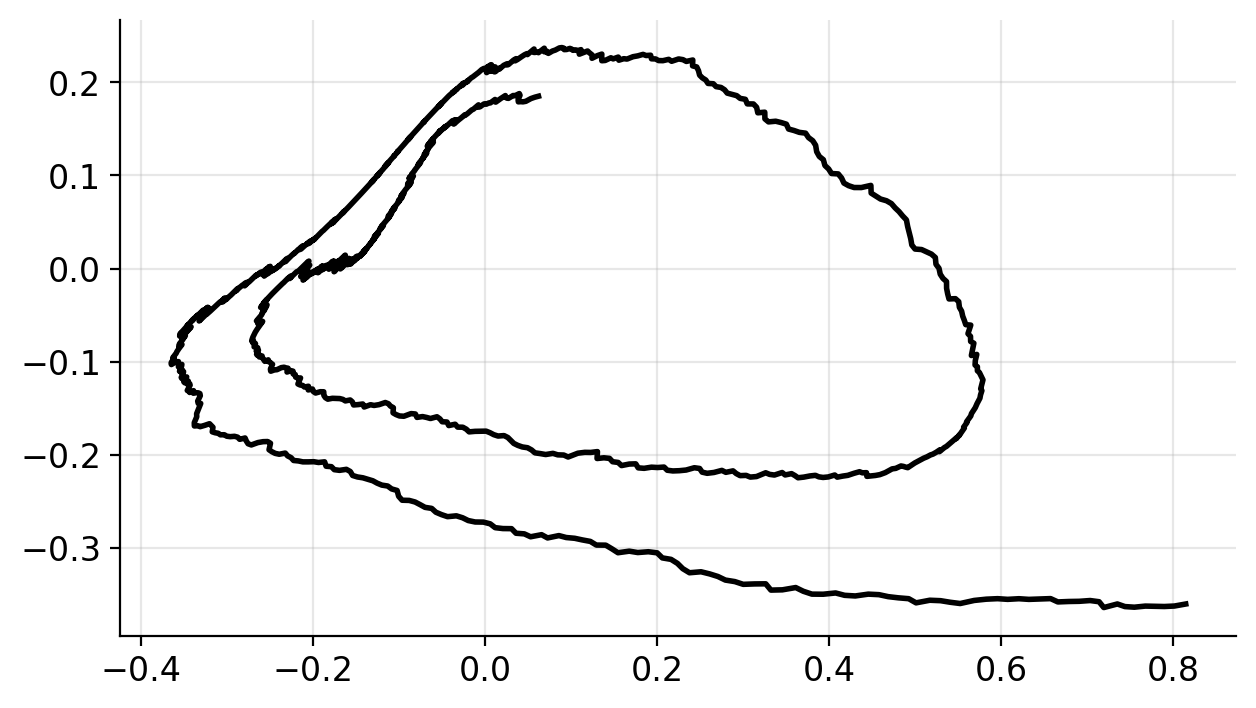

In [21]:
s = 8
s = 4
innovation_sim = innovation_sims_test[..., s]
latent_test = latent_sims_test[..., s]

plt.plot(*latent_test.T, c="black", linewidth=2)
plt.grid(alpha=0.3)
plt.savefig("sample-run.png", dpi=300, bbox_inches="tight")

## Filter

In [22]:
tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=0)
latent_filter = jnp.einsum("tkd,kd,tk->td", K, innovation_sim, tmask)

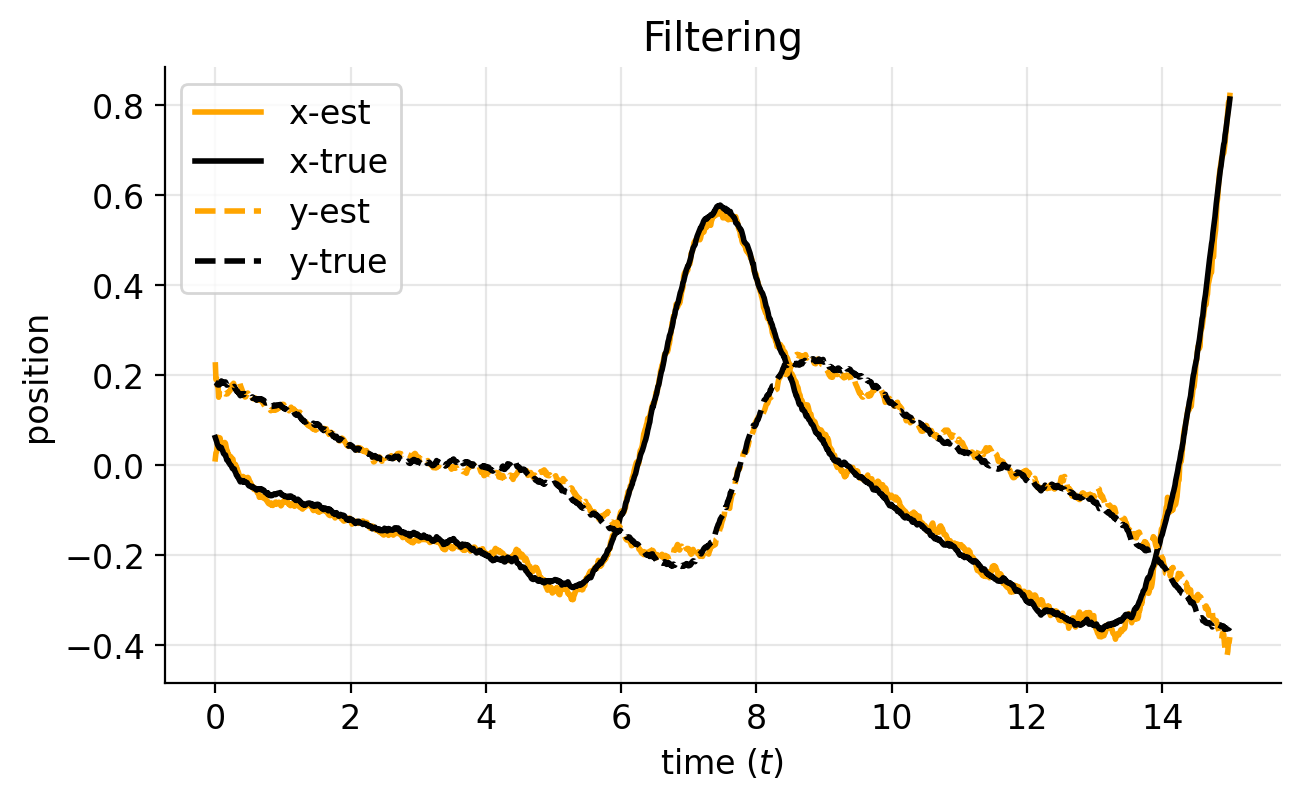

In [23]:
linestyles = ["-", "--"]
coords = ["x", "y"]
for d, (ls, coord) in enumerate(zip(linestyles, coords)):
    plt.plot(timesteps, latent_filter[:,d], c="orange", linewidth=2, linestyle=ls, label=f"{coord}-est")
    plt.plot(timesteps, latent_test[:,d], c="black", linewidth=2, linestyle=ls, label=f"{coord}-true")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Filtering")
plt.xlabel("time ($t$)")
plt.ylabel("position")
plt.savefig("test-sample-filter.png", dpi=300, bbox_inches="tight")

## Smoothing
We begin by computing the BLUP estimate over a sample $y_{1:T}$.

$$
    f_{t|T} = \sum_{k=1}^T{\bf K}_{t,k}\,\varepsilon_{k}
$$

In [24]:
latent_smooth = jnp.einsum("tkd,kd->td", K, innovation_sim)

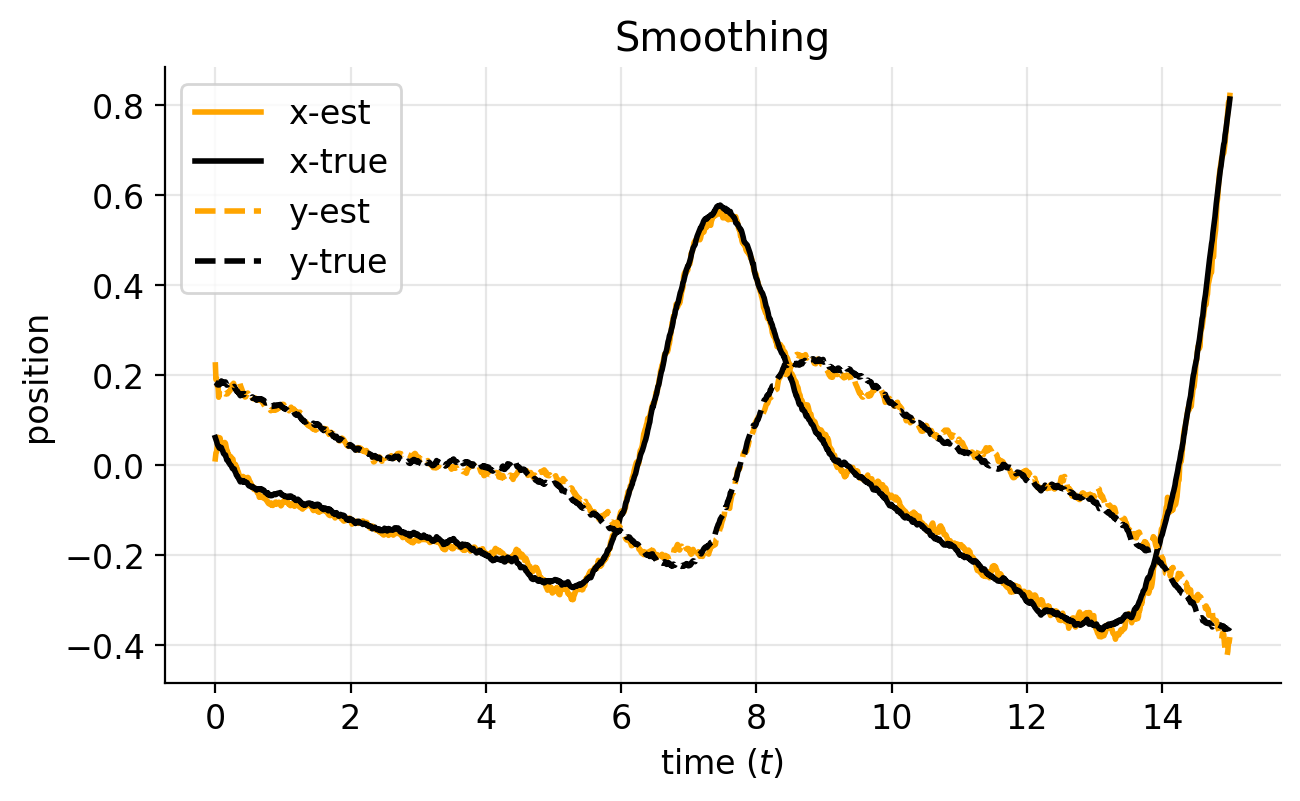

In [25]:
linestyles = ["-", "--"]
coords = ["x", "y"]
for d, (ls, coord) in enumerate(zip(linestyles, coords)):
    plt.plot(timesteps, latent_filter[:,d], c="orange", linewidth=2, linestyle=ls, label=f"{coord}-est")
    plt.plot(timesteps, latent_test[:,d], c="black", linewidth=2, linestyle=ls, label=f"{coord}-true")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Smoothing")
plt.xlabel("time ($t$)")
plt.ylabel("position")
plt.savefig("test-sample-smooth.png", dpi=300, bbox_inches="tight")

## Prediction

In [26]:
tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=-5)
latent_pred = jnp.einsum("tkd,kd,tk->td", K, innovation_sim, tmask)

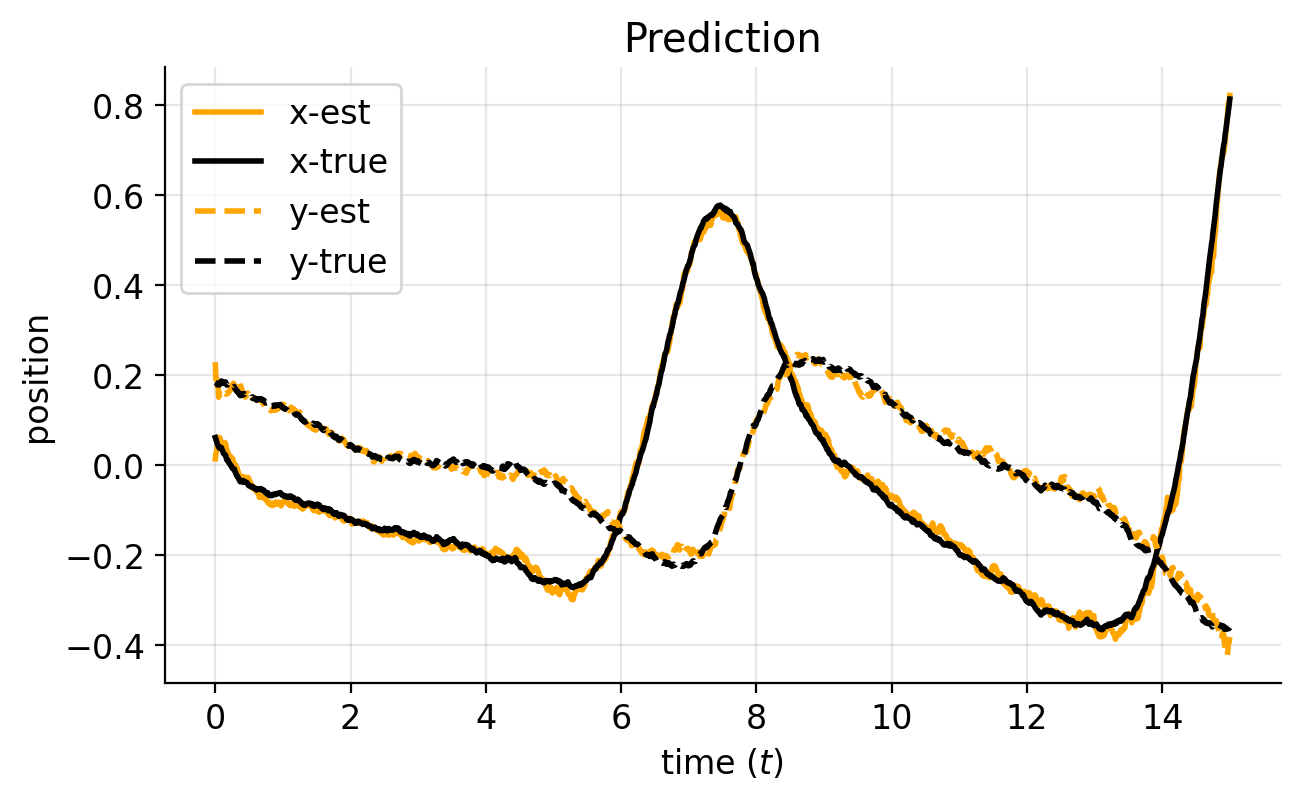

In [27]:
linestyles = ["-", "--"]
coords = ["x", "y"]
for d, (ls, coord) in enumerate(zip(linestyles, coords)):
    plt.plot(timesteps, latent_filter[:,d], c="orange", linewidth=2, linestyle=ls, label=f"{coord}-est")
    plt.plot(timesteps, latent_test[:,d], c="black", linewidth=2, linestyle=ls, label=f"{coord}-true")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Prediction")
plt.xlabel("time ($t$)")
plt.ylabel("position")
plt.savefig("test-sample-prediction.png", dpi=300, bbox_inches="tight")

## Multiple lags

In [35]:
samples_range = jnp.arange(1, n_steps + 1)

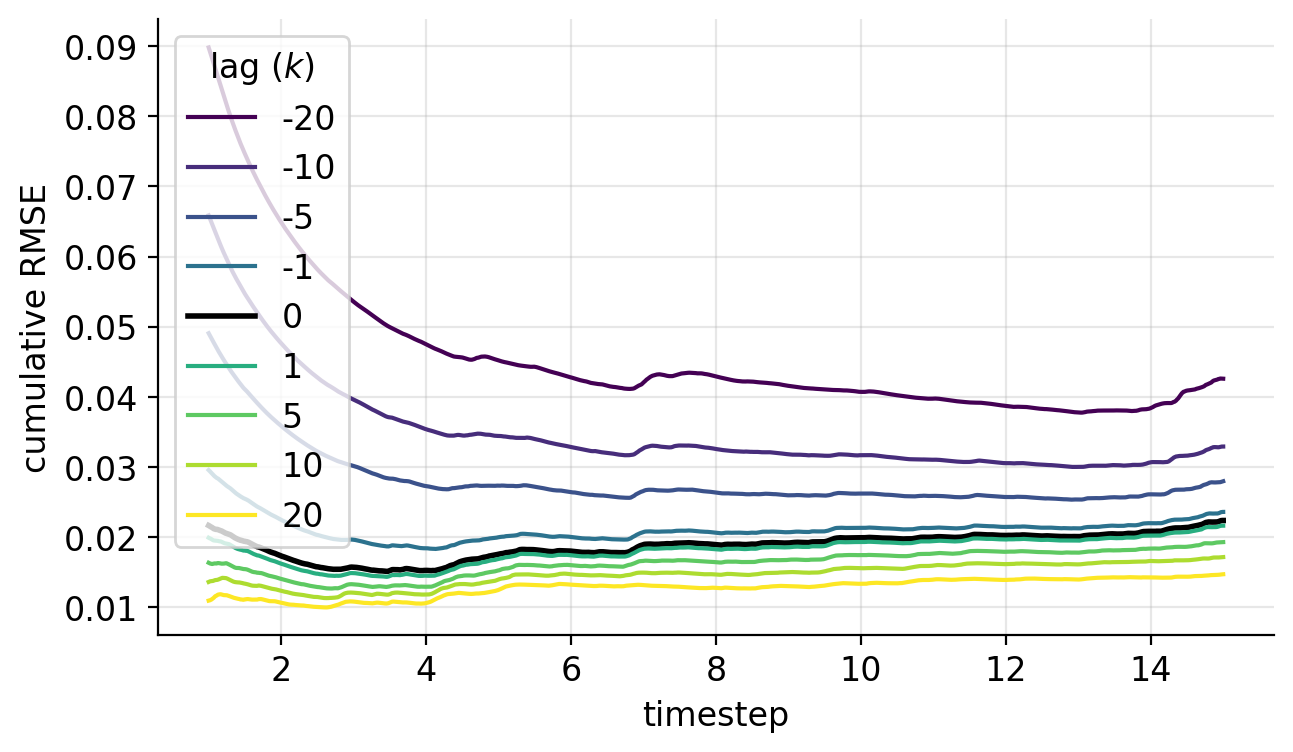

In [71]:
k_values = [-20, -10, -5, -1, 0, 1, 5, 10, 20]

colors = plt.cm.viridis(np.linspace(0, 1, len(k_values)))

for c, k in zip(colors, k_values):
    c = c if k != 0 else "black"
    lw = 1.5 if k != 0 else 2
    tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=k)
    latent_pred = jnp.einsum("tkd,kd,tk->td", K, innovation_sim, tmask)
    err = latent_pred - latent_test
    rmse = jnp.linalg.norm(err, axis=1) ** 2
    rmse = jnp.sqrt(rmse.cumsum() / samples_range)
    plt.plot(timesteps[100:], rmse[100:], c=c, label=k, linewidth=lw)

plt.legend(title="lag ($k$)")
plt.xlabel("timestep")
plt.ylabel("cumulative RMSE")
plt.grid(alpha=0.3)
plt.savefig("test-sample-errs.png", dpi=300, bbox_inches="tight")

## Fixed-lag smoothing

In [41]:
latent_sims_test.shape

(1500, 2, 100)

In [64]:
lags = np.arange(-100, 105, 5)

lag_errs = {}
lag_var = {}
for lag in lags:
    tmask = jnp.tril(jnp.ones((n_steps, n_steps)), k=lag)
    latent_fixed_lag = jnp.einsum("tkd,kds,tk->tds", K, innovation_sims_test, tmask)
    
    err_sims = jnp.linalg.norm(latent_sims_test - latent_fixed_lag, axis=1) ** 2
    err_sims = jnp.sqrt(err_sims.mean(axis=0))
    
    # err_sims = jnp.sqrt(jnp.power(latent_sims_test - latent_fixed_lag, 2).mean(axis=0))
    lag_errs[lag] = np.array(err_sims).mean(axis=-1)
    lag_var[lag] = np.array(err_sims).var(axis=-1)

lag_errs = pd.Series(lag_errs)
lag_var = pd.Series(lag_var)

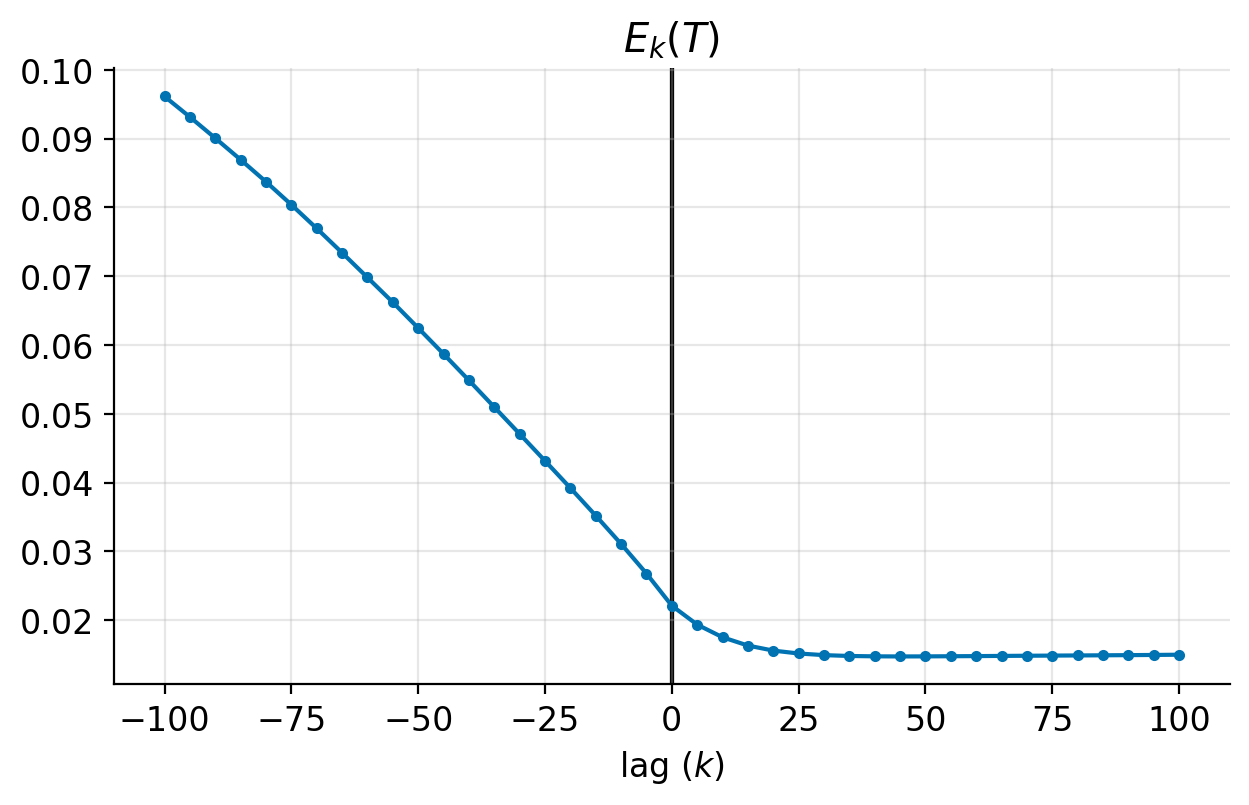

In [70]:
lag_errs.plot(marker="o", markersize=3)
plt.axvline(x=0, c="black", zorder=0)
plt.axvline(x=0, c="black", zorder=0, alpha=0.7)
plt.title("$E_k(T)$")
plt.xlabel("lag $(k)$")
plt.grid(alpha=0.3)
plt.savefig("errs-sample-lag.png", dpi=300, bbox_inches="tight")

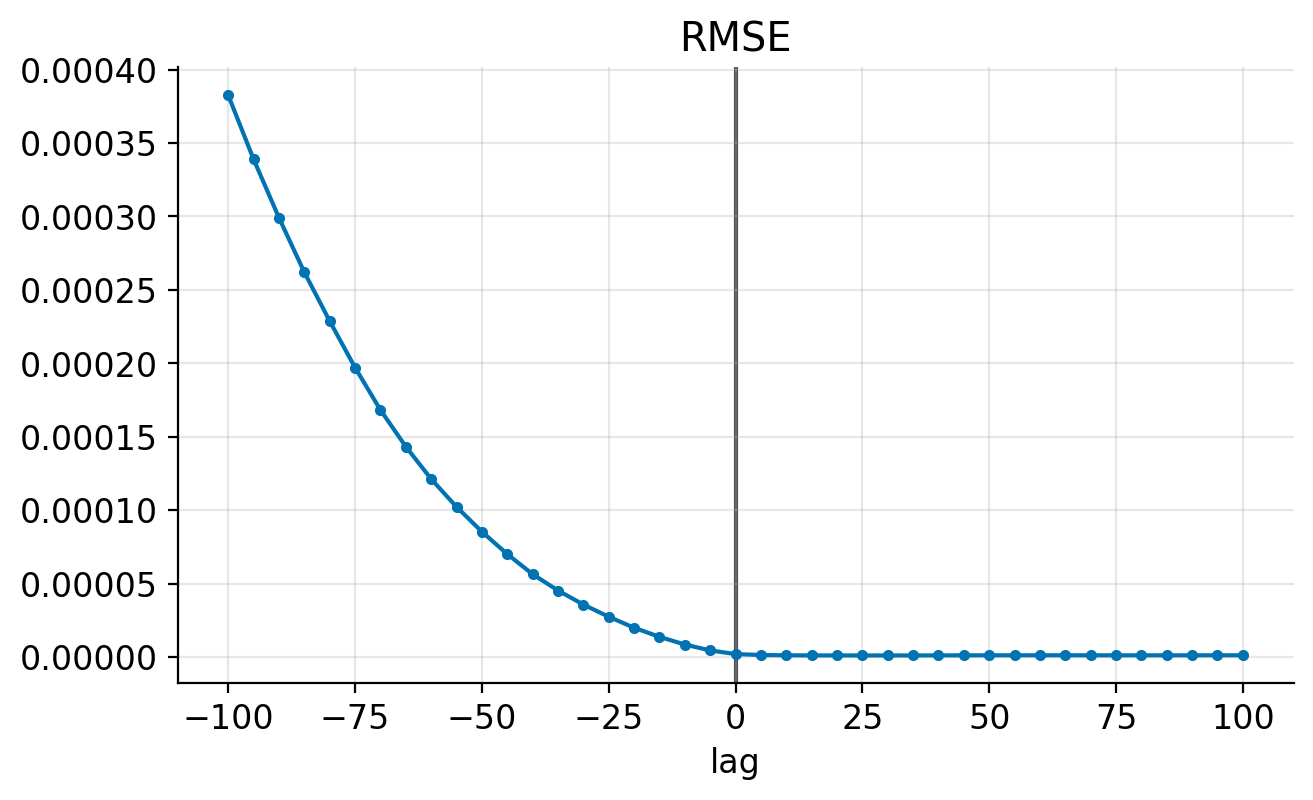

In [66]:
lag_var.plot(marker="o", markersize=3)
plt.axvline(x=0, c="black", zorder=0, alpha=0.7)
plt.title("RMSE")
plt.xlabel("lag")
plt.grid(alpha=0.3)
# plt.savefig("errs-sample-lag.png", dpi=300, bbox_inches="tight")